## 5. Results

- 5.1. Generating metrics on bootstraped samples
- 5.2. Comparison of Models by RMSE
- 5.3. Comparison of Models by R-squared
- 5.4. Comparison of Models by Fit Time
- 5.5 Generating Prediction Intervals Using `nonconformist` package
- 5.6. Generating Interval Score, Average Length, and Coverage

In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import ElasticNet
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
import pickle
import re
import warnings
warnings.filterwarnings('ignore')

In [11]:
results = pd.read_csv('data/4_validation_result.csv')
train_input = pd.read_csv('data/3_train_model_input.csv')
test_input = pd.read_csv('data/3_test_model_input.csv')

X_train = train_input.iloc[:,0:6]
y_train = train_input.iloc[:,-1]
X_test = test_input.iloc[:,0:6]
y_test = test_input.iloc[:,-1]

### 5.1. Generating metrics on bootstraped samples

In [12]:
bootstraps = []
for model in list(set(results.model.values)):
    model_df = results.loc[results.model == model]
    bootstrap = model_df.sample(n=50, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_boot = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time', 'score_time']
## PERFORMANCE EVALUATION METRICS
results_perf = results_boot.loc[~results_boot['metrics'].isin(time_metrics)] # get df without fit data
results_perf = results_perf.sort_values(by='values')
## FITTING TIME METRICS
results_fit_time = results_boot.loc[results_boot['metrics'].isin(time_metrics)] # df with fit data
results_fit_time = results_fit_time.sort_values(by='values')

In [13]:
metric_df = results_perf[results_perf.metrics == 'test_neg_mean_squared_error']
metric_df['values'] = (metric_df['values']*(-1))**(1/2)

### 5.2. Comparison of Models by RMSE

Text(0.5, 1.0, 'Comparison of Model by RMSE')

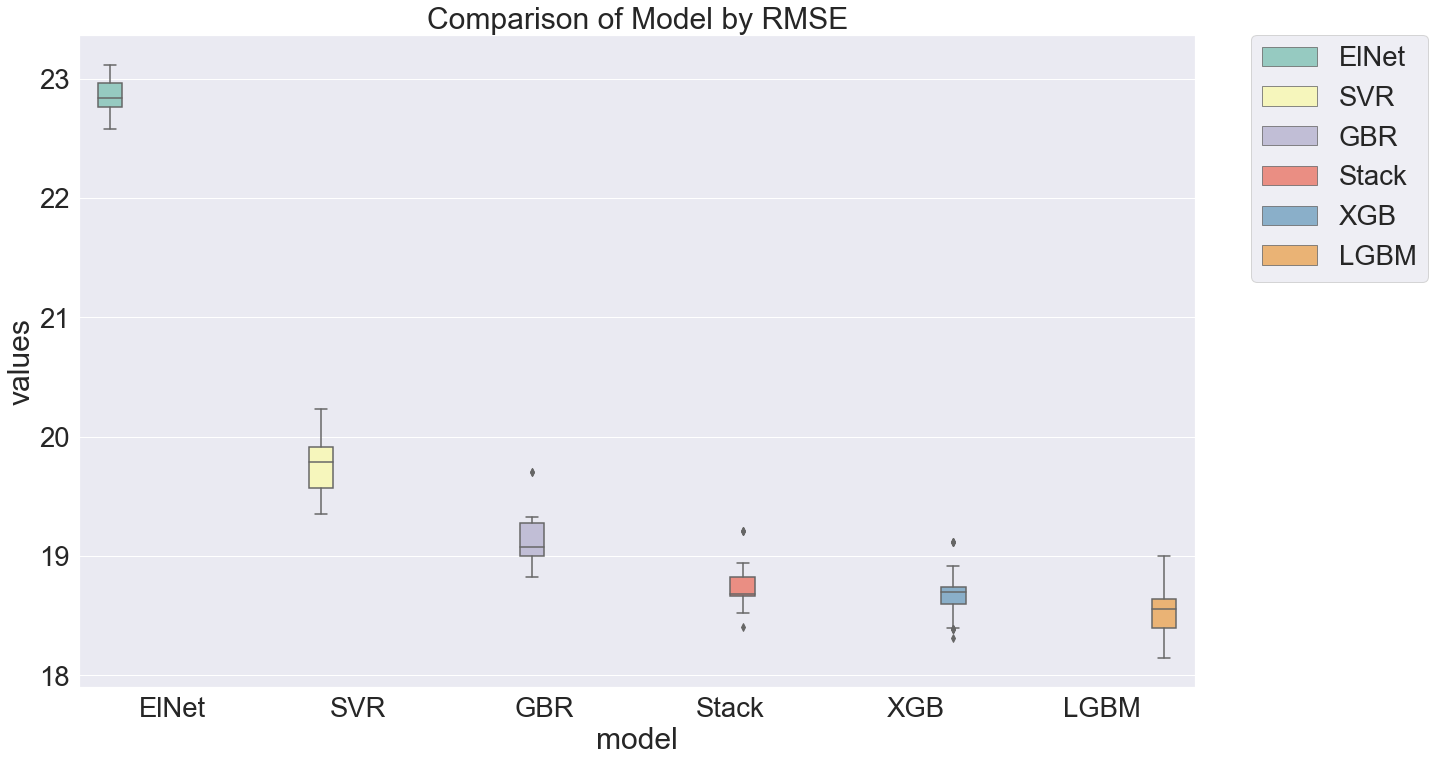

In [14]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="model", data=metric_df, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by RMSE')

In [15]:
metric_df = results_perf[results_perf.metrics == 'test_r2']

### 5.3. Comparison of Models by R-squared

Text(0.5, 1.0, 'Comparison of Model by R-squared')

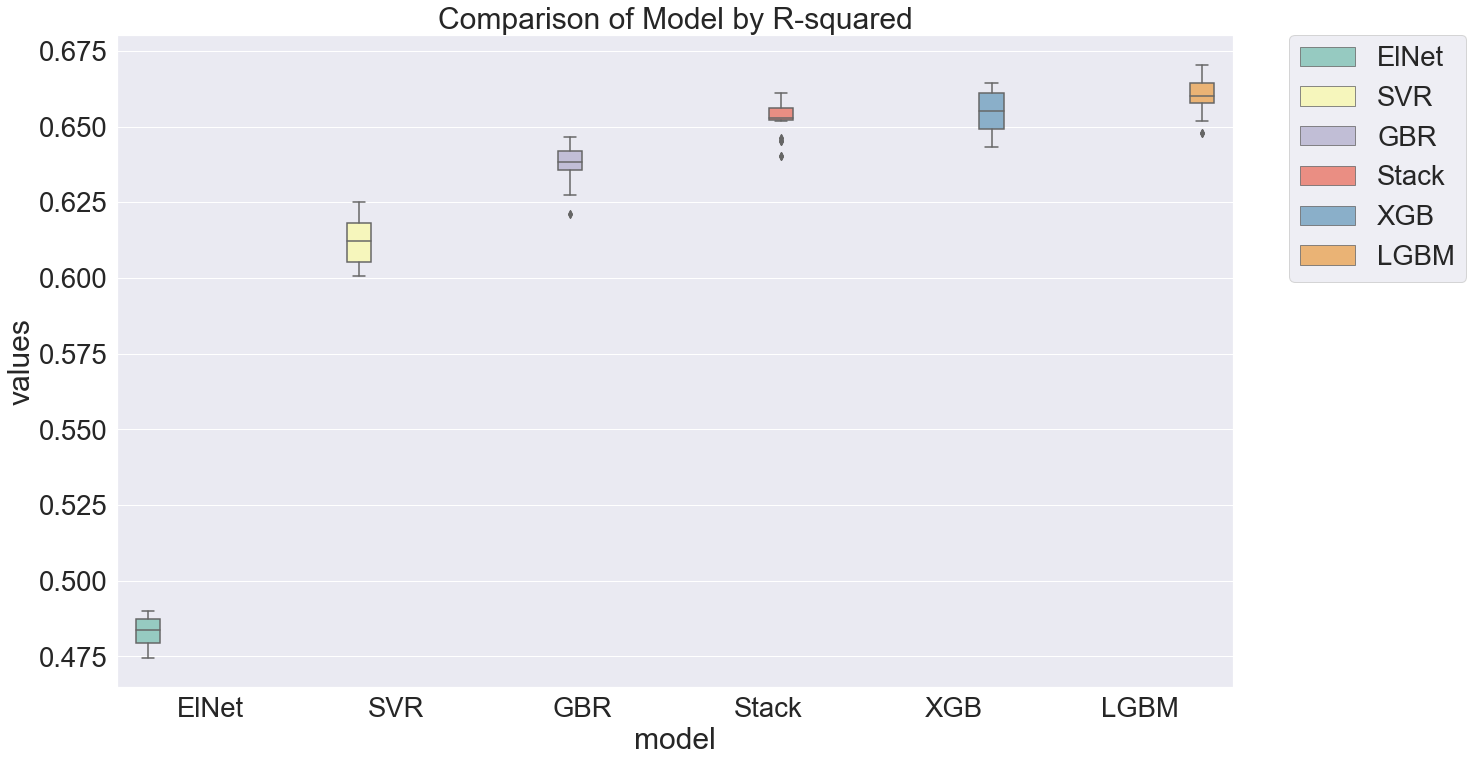

In [16]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="model", data=metric_df, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by R-squared')

### 5.4. Comparison of Models by Fit Time

Text(0.5, 1.0, 'Comparison of Model by Fit Time')

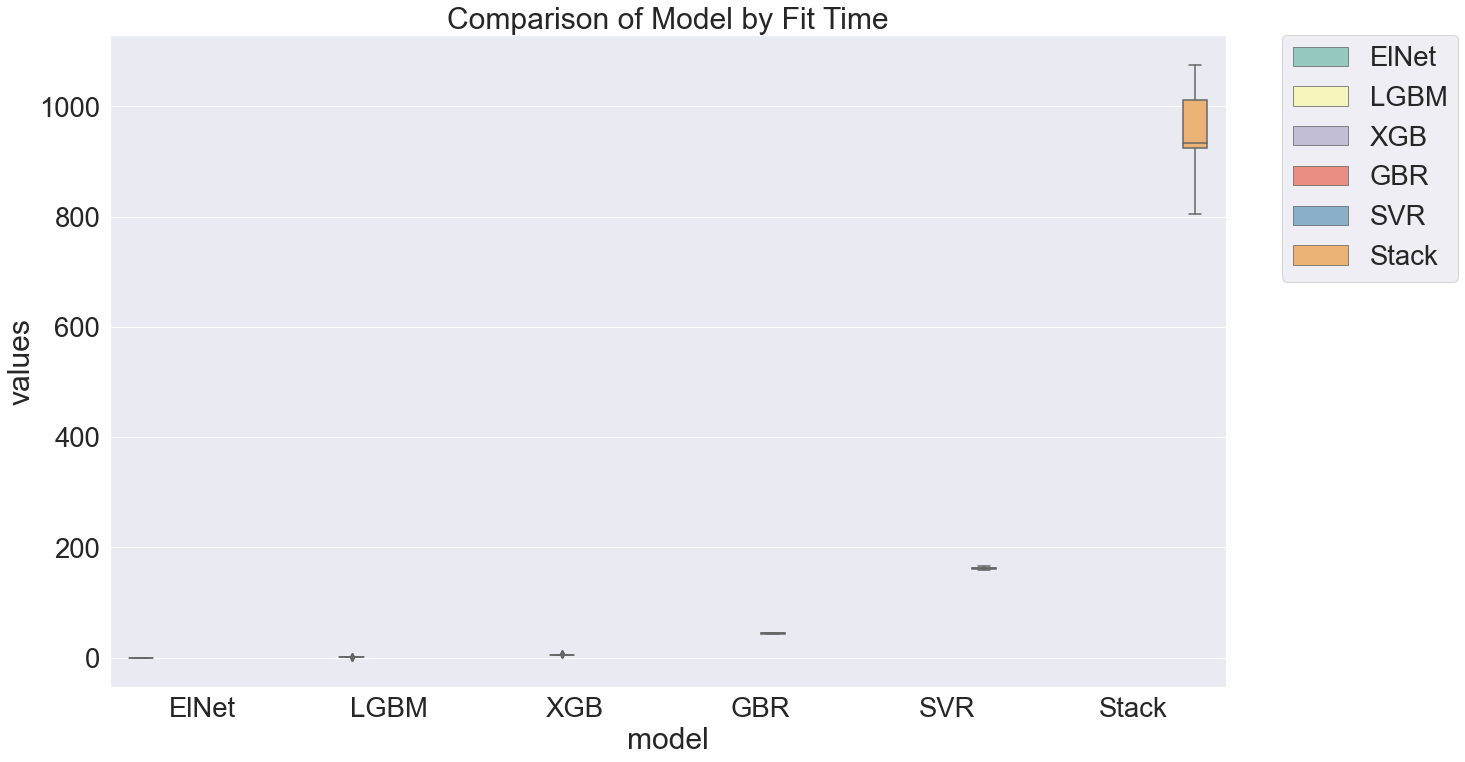

In [18]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="model", data=results_fit_time[results_fit_time.metrics =='fit_time'], palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

### 5.4.1. Zoomed in version of the above plot

Text(0.5, 1.0, 'Comparison of Model by FitTime')

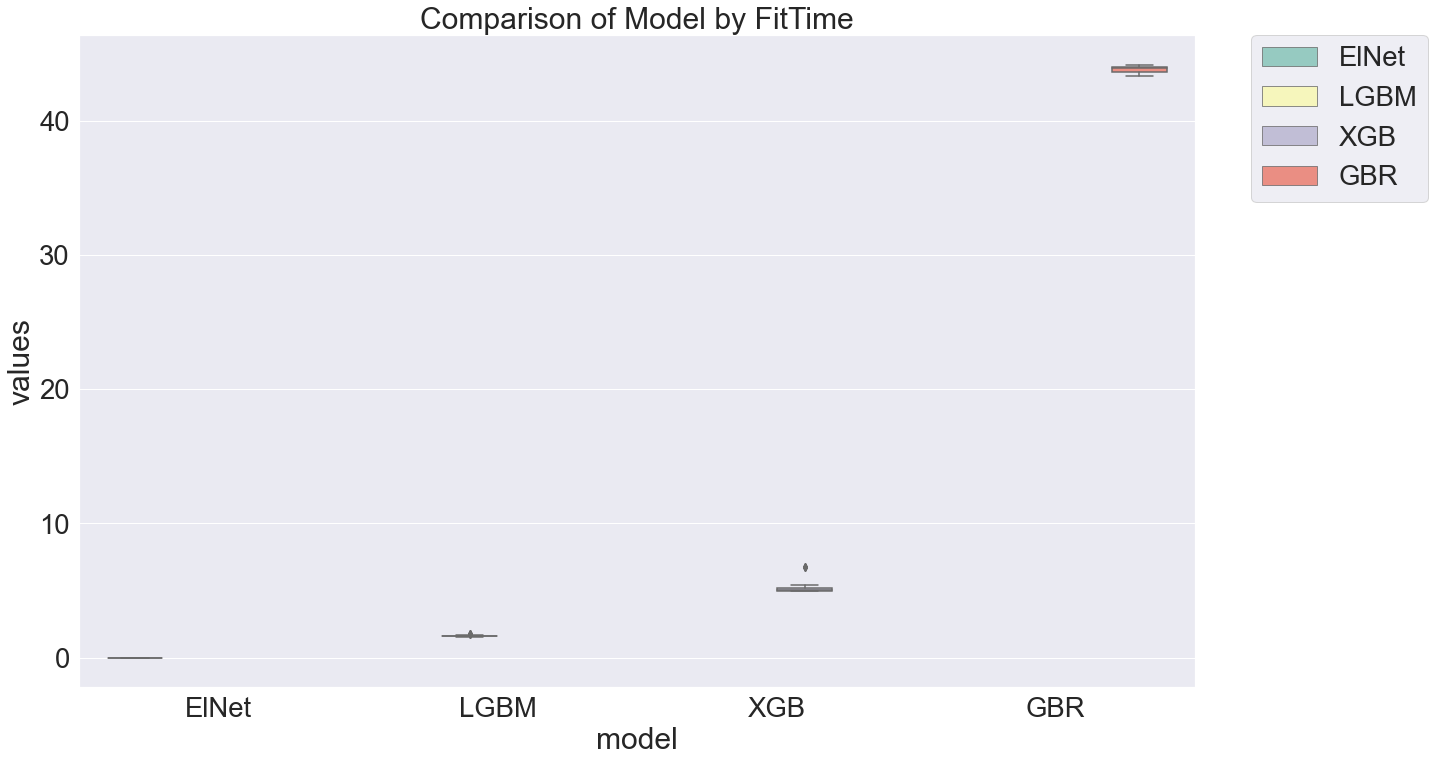

In [19]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="model", data=results_fit_time[(results_fit_time.metrics =='fit_time') & 
                                                                            (results_fit_time.model != 'Stack') &
                                                                           (results_fit_time.model != 'SVR')], palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by FitTime')

In [20]:
metric_df['values'] = (metric_df['values']*(-1))**(1/2)
metrics = list(set(results_perf.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_neg_mean_squared_error             test_neg_mean_absolute_error  \
                              std        mean                          std   
model                                                                        
ElNet                    5.752439 -522.935107                     0.077457   
GBR                      7.492853 -365.862060                     0.110616   
LGBM                     7.923413 -343.330318                     0.144040   
SVR                      8.630746 -390.206099                     0.110444   
Stack                    6.343870 -351.012838                     0.112639   
XGB                      7.242688 -349.469456                     0.123949   

                   test_r2            
            mean       std      mean  
model                                 
ElNet -17.323463  0.004135  0.483401  
GBR   -13.517830  0.006310  0.637950  
LGBM  -12.818062  0.006223  0.660545  
SVR   -13.601044  0.007421  0.612964  
Stack -13.139917  0.004777  0.652921  
XGB   -12.945504  0.006154  0.654938

In [21]:
time_metrics = list(set(results_fit_time.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

score_time             fit_time            
             std      mean        std        mean
model                                            
ElNet   0.000279  0.002969   0.001804    0.009839
GBR     0.001621  0.052708   0.253081   43.851669
LGBM    0.005508  0.108162   0.053539    1.621248
SVR     0.127122  9.512699   1.602329  162.321769
Stack   0.890605  9.319177  85.094888  953.122266
XGB     0.002308  0.014113   0.510327    5.268956

In [14]:
GBR = pickle.load(open('models/GBR.sav', 'rb'))
LGBM = pickle.load(open('models/LGBM.sav', 'rb'))
Stack = pickle.load(open('models/Stack.sav', 'rb'))
SVR = pickle.load(open('models/SVR.sav', 'rb'))
XGB = pickle.load(open('models/XGB.sav', 'rb'))
ElNet = pickle.load(open('models/ElNet.sav', 'rb'))

### 5.5 Generating Prediction Intervals Using `nonconformist` package

In [15]:
train_split = 0.8
cal_split = 0.2
n_total = X_train.shape[0]
n_train = int(train_split*n_total)
n_cal = int(cal_split*n_total) + n_train
train_data = X_train.iloc[:n_train, :]
train_target = y_train.iloc[:n_train]
cal_data = X_train.iloc[n_train:n_cal, :]
cal_target = y_train.iloc[n_train:n_cal]
test_data = X_test
test_target = y_test

In [16]:
#' @param model Object
#' @param level1 level to calculate one Prediction interval with significance 1-level1
#' @param level2 level to calculate second Prediction interval with significance 1-level2
#' @return two dataframes (in an array) containing the upper/lower bound for the prediction intervals based 
#'         on level1 and level2 for the specified model

def PI(model, level1, level2):
    
    # Default nonconformity measure
    nc = NcFactory.create_nc(model)
    # Inductive conformal regressor
    icp = IcpRegressor(nc)
    # Fit the ICP using the proper training set
    icp.fit(train_data.values, train_target.values)
    # Calibrate the ICP using the calibration set
    icp.calibrate(cal_data.values, cal_target.values)

    # Produce predictions for the test set
    prediction1 = icp.predict(test_data.values, significance=(1-level1))
    lower_1 = prediction1[:, 0]
    upper_1 = prediction1[:, 1]

    prediction2 = icp.predict(test_data.values, significance=(1-level2))
    lower_2 = prediction2[:, 0]
    upper_2 = prediction2[:, 1]

    df_50 = pd.DataFrame()
    df_80 = pd.DataFrame()
    df_50 = df_50.append(pd.DataFrame({'pred': model.predict(test_data.values),
                      'LB': lower_1,
                      'UB': upper_1}
                     ))
    
    df_80 = df_80.append(pd.DataFrame({'pred': model.predict(test_data.values),
                      'LB': lower_2,
                      'UB': upper_2}
                     ))
        
    return df_50, df_80

In [17]:
%%time
PI_LGBM = PI(LGBM,0.5,0.8)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
CPU times: user 5.54 s, sys: 79.5 ms, total: 5.62 s
Wall time: 1.59 s


In [18]:
%%time
PI_SVR = PI(SVR,0.5,0.8)

CPU times: user 3min 2s, sys: 1.5 s, total: 3min 3s
Wall time: 3min 6s


In [19]:
%%time
PI_ElNet = PI(ElNet,0.5,0.8)

CPU times: user 586 ms, sys: 43.3 ms, total: 630 ms
Wall time: 419 ms


In [20]:
%%time
PI_GBR = PI(GBR,0.5,0.8)

CPU times: user 43.1 s, sys: 386 ms, total: 43.5 s
Wall time: 44.3 s


In [21]:
%%time
PI_XGB = PI(XGB,0.5,0.8)

CPU times: user 17.3 s, sys: 180 ms, total: 17.5 s
Wall time: 4.9 s


In [22]:
%%time
PI_Stack = PI(Stack, 0.5,0.8)

CPU times: user 17min 10s, sys: 7.35 s, total: 17min 17s
Wall time: 14min 59s


### 5.6. Generating Interval Score, Average Length, and Coverage

In [23]:
#' @param predObj: array containing two dataframes containing upper and lower bound of the prediction interval of the specified level
#' @param actual: dataframe containing the reponse values
#' @param level: float
#' @return a dataframe containing the interval score, avg length and coverage for the specified predObj of a model

def intervalScore(predObj,actual,level):
    n = len(predObj)
    alpha = 1 - level
    upper = predObj.loc[:,'UB']
    lower = predObj.loc[:,'LB']
    ilow = (actual.values<lower)
    ihigh = (actual.values>upper)
    sumlength = sum(upper-lower)
    sumlow = sum(predObj.loc[ilow,'LB']-actual.values[ilow])*2/alpha
    sumhigh = sum(actual.values[ihigh]-predObj.loc[ihigh,'UB'])*2/alpha
    avglength = sumlength/n
    IS = (sumlength+sumlow+sumhigh)/n # average length + average under/over penalties
    cover = ((actual.values>= lower) & (actual.values<=upper)).mean()
    summ = pd.DataFrame(np.array([[level,avglength,IS,cover]]), columns = ['level','avglength', 'IS', 'cover'])
    return summ

In [24]:
intervalScore(PI_LGBM[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,17.292233,44.032818,0.493078


In [25]:
intervalScore(PI_LGBM[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,40.01516,68.963069,0.790261


In [26]:
intervalScore(PI_GBR[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,18.858984,45.449898,0.489322


In [27]:
intervalScore(PI_GBR[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,41.873085,70.157203,0.799513


In [28]:
intervalScore(PI_XGB[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,17.461028,44.205556,0.49113


In [29]:
intervalScore(PI_XGB[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,39.901018,69.033989,0.788104


In [30]:
intervalScore(PI_ElNet[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,26.71882,56.046959,0.499478


In [31]:
intervalScore(PI_ElNet[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,55.011715,82.333194,0.805983


In [32]:
intervalScore(PI_SVR[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,18.523849,46.230901,0.494539


In [33]:
intervalScore(PI_SVR[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,42.462843,72.444162,0.798678


In [34]:
intervalScore(PI_Stack[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,18.196567,44.446112,0.496974


In [35]:
intervalScore(PI_Stack[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,40.690589,69.124409,0.7936


| **Model** | **Level** | **Avg Length** | **IS** | **Coverage** | |
|---|---|---|---|---|---|
| LGBM | 0.5|17.292233|44.032818|0.493078 | |
| SVR | 0.5  | 18.523849|46.230901|0.494539 | |
| GBR | 0.5|18.858984|45.449898|0.489322 | |
|Elnet| 0.5|26.71882|56.046959|0.499478| |
| XGB | 0.5|17.461028|44.205556|0.49113 | |
| Stack | 0.5 | 18.196567|44.446112|0.496974 |  |

| **Model** | **Level** | **Avg Length** | **IS** | **Coverage** | |
|---|---|---|---|---|---|
| LGBM | 0.8|40.01516|68.963069|0.790261 | |
| SVR | 0.8 | 42.462843 | 72.444162 | 0.798678 | |
| GBR | 0.8|41.873085|70.157203|0.799513 | |
|ElNet| 0.8|55.011715|82.333194|0.805983 | |
| XGB | 0.8|39.901018|69.033989|0.788104 | |
| Stack | 0.8 | 40.690589 | 69.124409 |0.7936| |